In [6]:
import qiskit
import numpy as np, pandas as pd
%load_ext autoreload
%autoreload 2
import data, po, model, ast, csv

for num_assets in range(16,17):

    file_name = f'./result_{num_assets}.csv'
    result = pd.read_csv(file_name)
    for i in range(0, len(result)):
        asset_list = (result['assets'][i])
        array_string = asset_list.replace("[", "").replace("]", "").replace("'", "")
        asset_list = array_string.split()
        mu, sigma, _ = data.get_mu_sigma_specific('asset.csv', asset_list)
        numpy_result, qpo_result = (model.qpo(mu, sigma))
        
        file_name = f"compare_{num_assets}.csv"
        # check if file exists
        try:
            with open(file_name, 'r') as csvfile:
                pass
        except FileNotFoundError:
            with open(file_name, 'w') as csvfile:
                # Create a csv writer object
                csvwriter = csv.writer(csvfile)
                # Write the row to csv file
                csvwriter.writerow(['assets', 'numpy', 'qpo'])
        df = pd.read_csv(file_name)
        asset = df.assets.unique()
        row = [[str(asset_list),numpy_result, qpo_result]]
            
        if row[0][0] not in asset:
            with open(file_name, 'a') as csvfile:
                # Create a csv writer object
                # Check the value of first cell in row, if it is existing, then skip writing it
                
                csvwriter = csv.writer(csvfile)
                csvwriter.writerows(row)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1]
[0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1]
[0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1]
[1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0]
[1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1]
[0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1]
[1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1]
[0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0]
[0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1]


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1]
[1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0]
[1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1]
[0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1]
[0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0]
[1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0]
[0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1]
[1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1]
[0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1]
[0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1]
[0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1]
[0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1]
[0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 1]
[0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1]
[0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1]
[1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0]
[0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1]
[0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1]


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0]
[0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1]
[1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0]
[1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1]
[0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0]
[0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1]
[1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0]


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1]
[0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1]
[1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0]
[1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 0]
[0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0]
[0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0]
[0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 0]
[0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1]
[0 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0]
[0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1]
[1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0]
[1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 1]
[0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0]
[1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0]
[1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0]
[0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1]
[1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0]
[1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0]
[0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0]
[1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1]
[1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1]
[0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0]
[0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0]
[1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1]
[0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1]
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1]
[1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1]
[0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0]
[0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1]
[0 1 1 0 0 1 0

/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1]
[0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0]
[1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1]
[0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0]
[1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0]
[0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0]
[1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1]
[0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0]
[0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0]
[0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0]


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1]
[1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0]
[1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1]
[0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1]
[1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0]
[1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0]
[0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1]
[0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1]
[0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 1]
[1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0]
[0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1]


In [14]:
import qiskit
import numpy as np, pandas as pd
%load_ext autoreload
%autoreload 2
import data, po, model, ast, csv
import time
times = []
timesx = []
for num_assets in range(2,17):
    times = []
    file_name = f'./result/result_{num_assets}.csv'
    result = pd.read_csv(file_name)
    for i in range(0, 10):
        asset_list = (result['assets'][i])
        array_string = asset_list.replace("[", "").replace("]", "").replace("'", "")
        asset_list = array_string.split()
        mu, sigma, _ = data.get_mu_sigma_specific('asset.csv', asset_list)
        begin = time.time()
        numpy_result, qpo_result = (model.qpo(mu, sigma))
        end = time.time()
        times.append(end-begin)
    timesx.append(np.mean(times))
    print(f"Num assets {num_assets}: ", np.mean(times))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num assets 2:  0.0078067779541015625
Num assets 3:  0.011284422874450684
Num assets 4:  0.011734461784362793
Num assets 5:  0.02232699394226074
Num assets 6:  0.02306101322174072


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]
/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 7:  0.025965023040771484
Num assets 8:  0.029480600357055665


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 9:  0.05644092559814453


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 10:  0.06453001499176025


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 11:  0.0654184341430664


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]
/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 12:  0.08128306865692139
Num assets 13:  0.09692492485046386
Num assets 14:  0.12835533618927003


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 15:  0.18279435634613037
Num assets 16:  0.33434467315673827


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


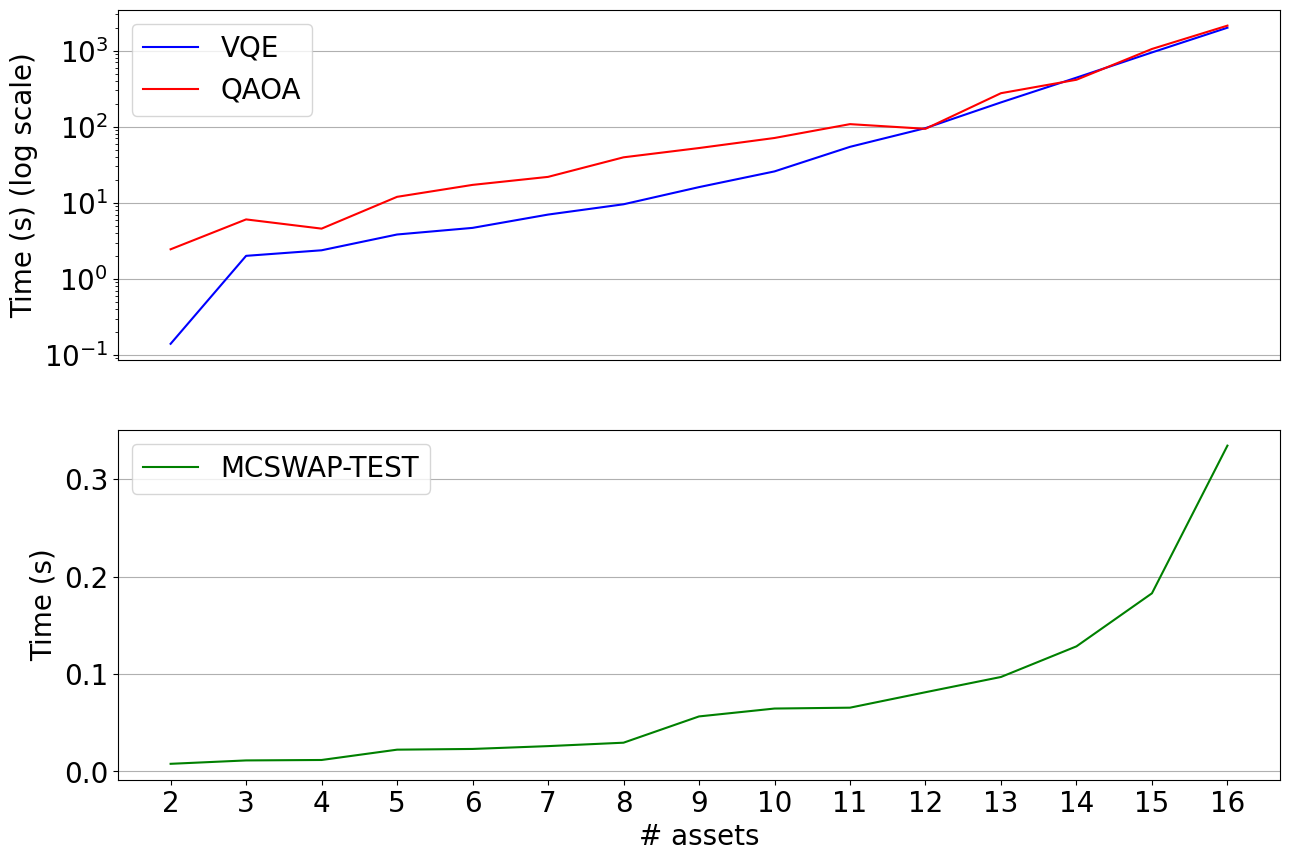

In [16]:
import matplotlib.pyplot as plt

times_qpo = [
    0.0078067779541015625,
    0.011284422874450684,
    0.011734461784362793,
    0.02232699394226074,
    0.02306101322174072,
    0.025965023040771484,
    0.029480600357055665,
    0.05644092559814453,
    0.06453001499176025,
    0.0654184341430664,
    0.08128306865692139,
    0.09692492485046386,
    0.12835533618927003,
    0.18279435634613037,
    0.33434467315673827
]

times_vqe = [
0.13980396588643393,
2.0053698221842446,
2.372962713241577,
3.8271216551462808,
4.675742785135905,
6.994110663731893,
9.553435246149698,
16.06194305419922,
25.846980571746826,
54.378950119018555,
95.8115537961324,
208.7883736292521,
441.75880455970764,
947.4926701784134,
2003.292198753357
]

times_qoao = [
    2.4453770319620767,
    6.042410532633464,
    4.570803721745809,
     11.968478600184122,
    17.18497435251872,
    21.898648023605347,
    39.59054478009542,
    52.432917992273964,
    71.09543506304423,
    108.12375195821126,
    93.88868729273479,
    275.8987986246745,
    414.41712800661725,
    1052.5821846723557,
    2133.292198753357
]
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plt.rcParams.update({'font.size': 20})


ax[0].plot(range(2,17),times_vqe, color = 'blue', label='VQE')
ax[0].plot(range(2,17),times_qoao, color = 'red', label='QAOA')
ax[1].plot(range(2,17),times_qpo, color = 'green', label='MCSWAP-TEST')

ax[1].set_xticks(range(2,17))
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
ax[0].set_ylabel('Time (s) (log scale)')
ax[1].set_ylabel('Time (s)')
plt.xlabel('# assets')
ax[0].legend()
ax[1].legend()
ax[0].grid(axis='y')
ax[1].grid(axis='y')
ax[0].set_xticks([])
plt.savefig('time.eps', format='eps')
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt, csv
import datetime, time
import data, po, model
import ast, pandas as pd
from qsee.core.ansatz import Wchain_zxz
%load_ext autoreload
%autoreload 2

times_x_qoao = []
times_x_vqe = []
for num_assets in range(2,17):
    times_vqe = []
    times_qoao = []
    for i in range(3):    
        mu, sigma, asset_list = data.get_mu_sigma('asset.csv', num_assets)
        qp = po.to_po(mu, sigma, num_assets = num_assets, q = 0.5)
        begin = time.time()
        resultQOAO = model.qoao(qp)
        end = time.time()
        times_qoao.append(end-begin)
        begin = time.time()
        resultVQE = model.vqe(qp, Wchain_zxz(num_assets, int(np.ceil(num_assets/2))))
        end = time.time()
        times_vqe.append(end-begin)
    times_x_qoao.append(np.mean(times_qoao))
    times_x_vqe.append(np.mean(times_vqe))
    print("QOAO {num_assets}: ", np.mean(times_qoao))
    print("VQE {num_assets}: ", np.mean(times_vqe))
plt.plot(range(2,17),times_x_qoao, label = 'QOAO')
plt.plot(range(2,17),times_x_vqe, label = 'VQE')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
QOAO {num_assets}:  2.4453770319620767
VQE {num_assets}:  0.13980396588643393
QOAO {num_assets}:  6.042410532633464
VQE {num_assets}:  2.0053698221842446
QOAO {num_assets}:  4.570803721745809
VQE {num_assets}:  2.372962713241577
QOAO {num_assets}:  11.968478600184122
VQE {num_assets}:  3.8271216551462808
QOAO {num_assets}:  17.18497435251872
VQE {num_assets}:  4.675742785135905
QOAO {num_assets}:  21.898648023605347
VQE {num_assets}:  6.994110663731893
QOAO {num_assets}:  39.59054478009542
VQE {num_assets}:  9.553435246149698
QOAO {num_assets}:  52.432917992273964
VQE {num_assets}:  16.06194305419922
QOAO {num_assets}:  71.09543506304423
VQE {num_assets}:  25.846980571746826
QOAO {num_assets}:  108.12375195821126
VQE {num_assets}:  54.378950119018555
QOAO {num_assets}:  93.88868729273479
VQE {num_assets}:  95.8115537961324
QOAO {num_assets}:  275.8987986246745
VQE {num_assets}:  208.7883736292521
QO

KeyboardInterrupt: 

In [39]:
# create 8-dimensional binary vector
for i in [2,4,8,16,32,64]:
    x = np.random.randint(2, size=i)
    x = x /np.sqrt(np.sum(x))
    qc = qiskit.QuantumCircuit(int(np.log2(len(x))))
    qc.prepare_state(x)
    from qiskit.compiler import transpile
    from qiskit.providers.fake_provider import FakeQasmSimulator
    qc1 = transpile(qc, backend = FakeQasmSimulator())

    print(qc1.depth())

1
1
10
26
57
118


In [36]:



mu, sigma, _ = data.get_mu_sigma_specific('asset.csv', ['ATMUSDT','SOLUSDT','BNXUSDT', 'AAVEUSDT', 'APTUSDT'])
print(mu, sigma)

[-0.0029036236691319084, -0.0026702570589396614, -0.011380828801780924, 0.000619347729741717, -0.00527452174872208] [[0.00106326 0.00061676 0.00125094 0.00066726 0.00084313]
 [0.00061676 0.00145862 0.00140272 0.00107915 0.00136494]
 [0.00125094 0.00140272 0.00309352 0.00132747 0.00200171]
 [0.00066726 0.00107915 0.00132747 0.00203238 0.00127067]
 [0.00084313 0.00136494 0.00200171 0.00127067 0.00206379]]
